# MUML -  Feature selection

In [2]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from kneed import KneeLocator
from tqdm.auto import tqdm
from xgboost import XGBClassifier
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Methods

In [21]:
def cond_mutual_info(X, Y, Z):
    mutual_info = 0
    for i in np.unique(Z):
        ind = np.where(Z==i)[0]
        X_cond = X[ind]
        Y_cond = Y[ind]
        mutual_info += (len(ind)/len(Z)) * mutual_info_score(X_cond, Y_cond)
    return mutual_info

def J_mrmr(x, y, X, selected):
    return mutual_info_score(x, y) - 1/len(selected) * \
        np.sum([mutual_info_score(x, X[:, i]) for i in selected])

def J_cmim(x, y, X, selected):
    return mutual_info_score(x, y) - \
        np.max([(mutual_info_score(x, X[:, i]) - cond_mutual_info(x, X[:, i], y)) for i in selected])

def criterion_feature_selection(X, y, criterion):
    p = X.shape[1]
    features_left = list(range(p))
    mi_scores = [mutual_info_score(X[:, i], y) for i in range(p)]
    candidate = np.argmax(mi_scores)
    selected = [candidate]
    features_left.remove(candidate)

    accuracies = []
    accuracies.append(cross_val_score(LogisticRegression(max_iter=1000, n_jobs=-1),
                                       X[:, selected], y, scoring='accuracy', cv=3, n_jobs=-1).mean())
    
    for _ in range(p-1):
        crit_scores = [criterion(X[:, i], y, X, selected) for i in features_left]
        candidate = features_left[np.argmax(crit_scores)]
        selected.append(candidate)
        features_left.remove(candidate)
        accuracies.append(cross_val_score(LogisticRegression(max_iter=1000, n_jobs=-1),
                                           X[:, selected], y, scoring='accuracy', cv=3, n_jobs=-1).mean())
    
    kneedle = KneeLocator(range(1, p+1), accuracies, curve='concave',
                           direction='increasing', interp_method='polynomial')
    knee = kneedle.knee
    selected = selected[:knee]

    # kneedle.plot_knee_normalized(xlabel='Number of features normalized', ylabel='Accuracy normalized', title='Knee point detection')
    # plt.show()

    return selected

def svm_feature_selection(X, y):
    svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
    sfs = RFECV(estimator=svc, step=1, cv=3, n_jobs=-1, scoring='accuracy')
    sfs.fit(X, y)
    return list(np.where(sfs.support_)[0])

def rf_feature_selection(X, y):
    clf = SelectFromModel(RandomForestClassifier(n_estimators=100, n_jobs=-1), threshold='1.25*mean')
    clf.fit(X, y)
    return list(np.where(clf.get_support())[0])

In [22]:
def preprocess_data(X, y):
    X = pd.DataFrame(StandardScaler().fit_transform(X))
    X_disc = X.apply(lambda col: pd.cut(col, bins=10, labels=False).astype(int)).values
    y = LabelEncoder().fit_transform(y)

    return X_disc, X.values, y

## Artificial dataset 1

In [27]:
def generate_data(n_samples, n_features, n_informative, n_combine, n_classes):
    X, _ = make_classification(n_samples=n_samples, n_features=n_informative,
                                n_informative=n_informative, n_redundant=0)

    coefficients = np.random.uniform(-1, 1, size=n_informative)
    b = np.random.uniform(-1, 1)
    y = np.dot(X[:, :n_informative], coefficients) + b

    classes = pd.qcut(y, n_classes, labels=False, duplicates='drop')
    y = classes

    combinations = np.random.rand(n_informative, n_combine)
    X_combine = np.dot(X[:, :n_informative], combinations)

    X_distractor = np.random.rand(n_samples, n_features - n_informative - n_combine)

    X = np.hstack((X, X_combine, X_distractor))

    noise = np.random.normal(0, 0.05, X.shape)
    X += noise

    return X, y

In [28]:
mrmr_features = []
cmim_features = []
svm_features = []
rf_features = []

for i in tqdm(range(10), total=10):
    X, y = generate_data(1000, 30, 5, 10, 2)
    X_disc, X, y = preprocess_data(X, y)

    selected_svm = svm_feature_selection(X, y)
    selected_rf = rf_feature_selection(X, y)
    selected_mrmr = criterion_feature_selection(X_disc, y, J_mrmr)
    selected_cmim = criterion_feature_selection(X_disc, y, J_cmim)

    svm_features.append(selected_svm)
    rf_features.append(selected_rf)
    mrmr_features.append(selected_mrmr)
    cmim_features.append(selected_cmim)

  0%|          | 0/10 [00:00<?, ?it/s]

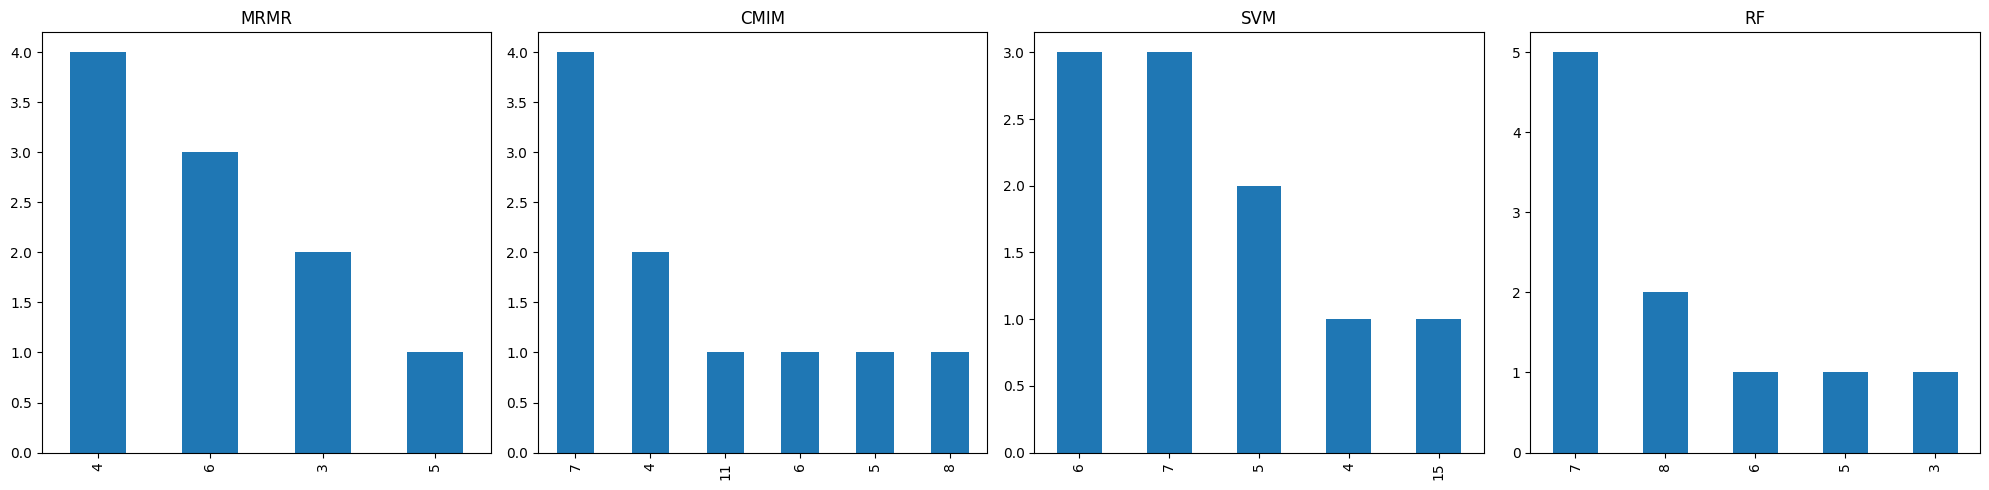

In [29]:
lengths_mrmr = [len(sublist) for sublist in mrmr_features]
lengths_cmim = [len(sublist) for sublist in cmim_features]
lengths_svm = [len(sublist) for sublist in svm_features]
lengths_rf = [len(sublist) for sublist in rf_features]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

pd.Series(lengths_mrmr).value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('MRMR')
pd.Series(lengths_cmim).value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('CMIM')
pd.Series(lengths_svm).value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('SVM')
pd.Series(lengths_rf).value_counts().plot(kind='bar', ax=axs[3])
axs[3].set_title('RF')

plt.tight_layout()
plt.show()

In [30]:
flatt_mrmr = np.array([item for sublist in mrmr_features for item in sublist]).reshape(-1)
flatt_cmim = np.array([item for sublist in cmim_features for item in sublist]).reshape(-1)
flatt_svm = np.array([item for sublist in svm_features for item in sublist]).reshape(-1)
flatt_rf = np.array([item for sublist in rf_features for item in sublist]).reshape(-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

pd.Series(flatt_mrmr).value_counts()[:5].plot(kind='bar', ax=axs[0])
axs[0].set_title('MRMR')
pd.Series(flatt_cmim).value_counts()[:5].plot(kind='bar', ax=axs[1])
axs[1].set_title('CMIM')
pd.Series(flatt_svm).value_counts()[:5].plot(kind='bar', ax=axs[2])
axs[2].set_title('SVM')
pd.Series(flatt_rf).value_counts()[:5].plot(kind='bar', ax=axs[3])
axs[3].set_title('RF')

plt.tight_layout()
plt.show()

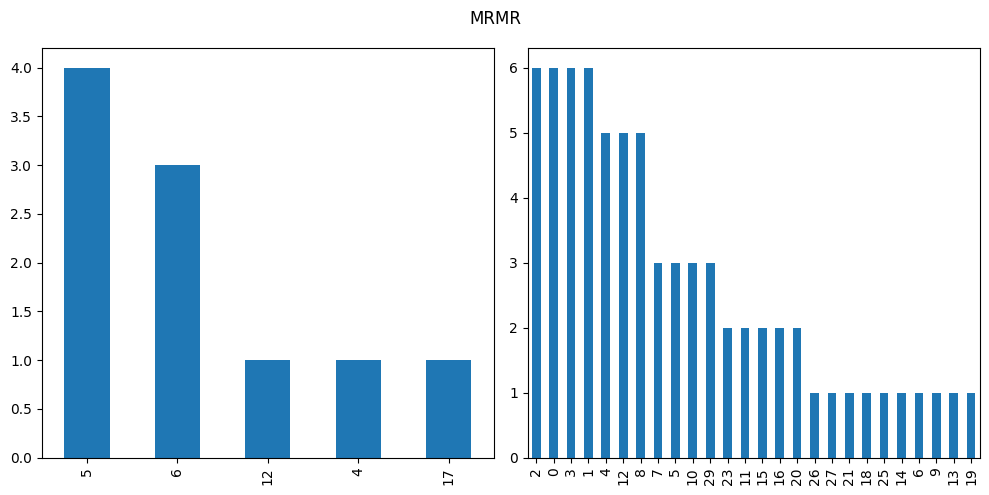

In [20]:
flatt = np.array([item for sublist in mrmr_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in mrmr_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('MRMR')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

In [21]:
flatt = np.array([item for sublist in cmim_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in cmim_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('CMIM')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

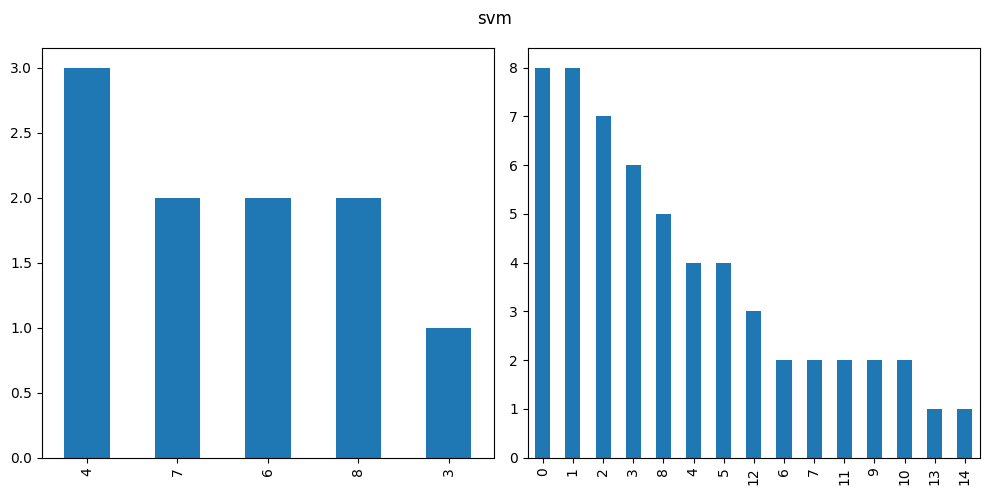

In [22]:
flatt = np.array([item for sublist in svm_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in svm_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('svm')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

In [23]:
flatt = np.array([item for sublist in rf_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in rf_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Random Forest')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

## Artificial dataset 2

In [32]:
# XOR dataset

def generate_xor(n_samples):
    X_0 = np.random.randint(0, 2, n_samples)
    X_1 = np.random.randint(0, 2, n_samples)
    X_2 = np.logical_xor(X_0, X_1).astype(int)
    X_3 = np.random.randint(0, 2, n_samples)
    X_4 = np.logical_xor(X_2, X_3).astype(int)
    X_5 = np.random.randint(0, 2, n_samples)
    X_6 = np.random.randint(0, 2, n_samples)

    X = np.vstack((X_0, X_1, X_2, X_3, X_4, X_5, X_6)).T
    y = np.logical_xor(X_0, X_4).astype(int)

    return X, y

In [33]:
mrmr_features = []
cmim_features = []
svm_features = []
rf_features = []

for i in tqdm(range(10), total=10):
    X, y = generate_xor(1000)

    selected_svm = svm_feature_selection(X, y)
    selected_rf = rf_feature_selection(X, y)
    selected_mrmr = criterion_feature_selection(X, y, J_mrmr)
    selected_cmim = criterion_feature_selection(X, y, J_cmim)

    svm_features.append(selected_svm)
    rf_features.append(selected_rf)
    mrmr_features.append(selected_mrmr)
    cmim_features.append(selected_cmim)

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
lengths_mrmr = [len(sublist) for sublist in mrmr_features]
lengths_cmim = [len(sublist) for sublist in cmim_features]
lengths_svm = [len(sublist) for sublist in svm_features]
lengths_rf = [len(sublist) for sublist in rf_features]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

pd.Series(lengths_mrmr).value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('MRMR')
pd.Series(lengths_cmim).value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('CMIM')
pd.Series(lengths_svm).value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('SVM')
pd.Series(lengths_rf).value_counts().plot(kind='bar', ax=axs[3])
axs[3].set_title('RF')

plt.tight_layout()
plt.show()

In [35]:
flatt_mrmr = np.array([item for sublist in mrmr_features for item in sublist]).reshape(-1)
flatt_cmim = np.array([item for sublist in cmim_features for item in sublist]).reshape(-1)
flatt_svm = np.array([item for sublist in svm_features for item in sublist]).reshape(-1)
flatt_rf = np.array([item for sublist in rf_features for item in sublist]).reshape(-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

pd.Series(flatt_mrmr).value_counts()[:5].plot(kind='bar', ax=axs[0])
axs[0].set_title('MRMR')
pd.Series(flatt_cmim).value_counts()[:5].plot(kind='bar', ax=axs[1])
axs[1].set_title('CMIM')
pd.Series(flatt_svm).value_counts()[:5].plot(kind='bar', ax=axs[2])
axs[2].set_title('SVM')
pd.Series(flatt_rf).value_counts()[:5].plot(kind='bar', ax=axs[3])
axs[3].set_title('RF')

plt.tight_layout()
plt.show()

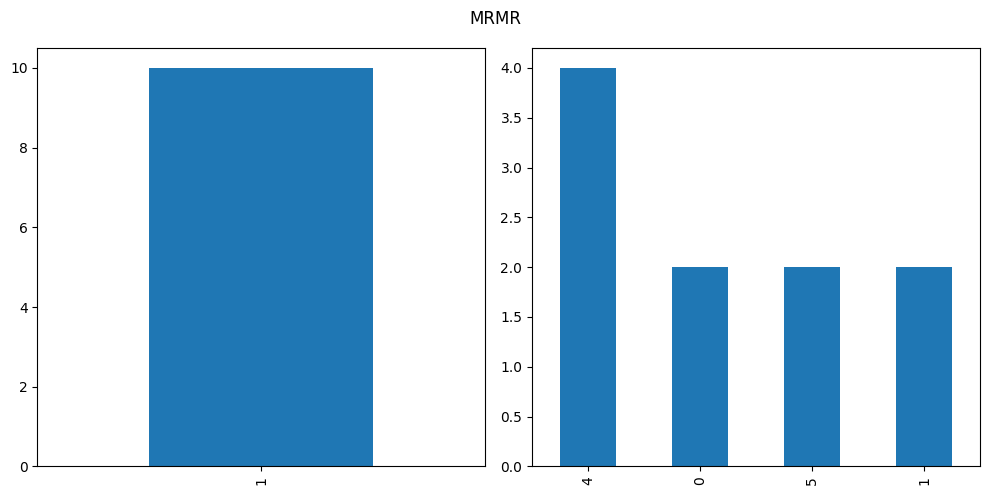

In [26]:
flatt = np.array([item for sublist in mrmr_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in mrmr_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('MRMR')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

In [27]:
flatt = np.array([item for sublist in cmim_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in cmim_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('CMIM')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

In [28]:
flatt = np.array([item for sublist in svm_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in svm_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('svm')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0])
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

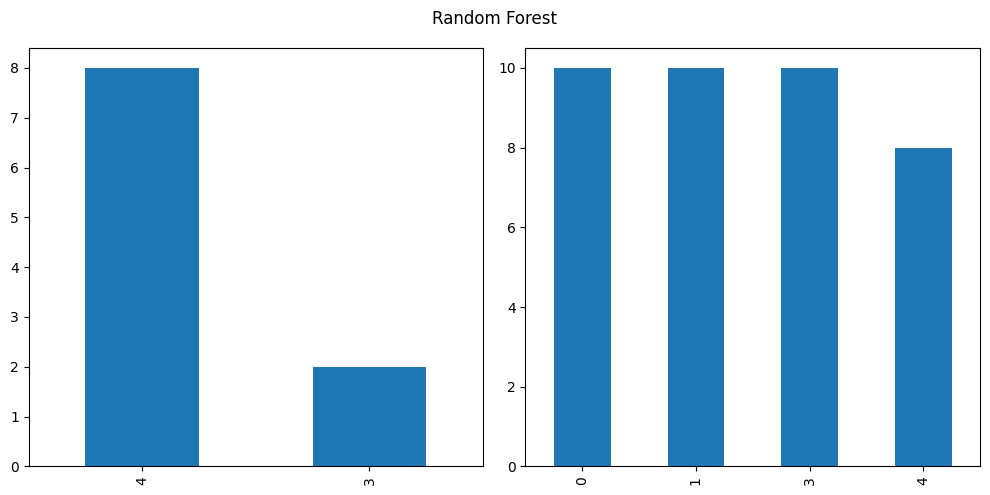

In [29]:
flatt = np.array([item for sublist in rf_features for item in sublist]).reshape(-1)
lengths = [len(sublist) for sublist in rf_features]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Random Forest')
pd.Series(lengths).value_counts().plot(kind='bar', ax=axs[0], title='Number of features')
pd.Series(flatt).value_counts().plot(kind='bar', ax=axs[1])
plt.tight_layout()
plt.show()

## Real world datasets

### Sports articles

In [30]:
df = pd.read_excel('./datasets/features.xlsx')
df = df.iloc[:, 2:]
df.head()

Label  totalWordsCount  semanticobjscore  semanticsubjscore  CC  CD  \
0  objective              109                 0                  1   7   9   
1  objective              309                21                  4   1  19   
2  objective              149                 6                  1   8  14   
3  objective              305                18                  5   7  26   
4  objective              491                23                  8  33  47   

   DT  EX  FW  INs  ...  pronouns2nd  pronouns3rd  compsupadjadv  past  \
0   0   5   8    6  ...            0            3              0    11   
1   1   4  35   23  ...            0           10              0    13   
2   0   5  15   11  ...            0            2              0     8   
3   0  10  37   21  ...            0            8              3    13   
4   0  12  61   36  ...            0           16              2    34   

   imperative  present3rd  present1st2nd  sentence1st  sentencelast  \
0           0           0              0            0             1   
1           0          14              9            1             1   
2           0           3              2            1             1   
3           1           7              1            1             1   
4           1           5              6            1             1   

   txtcomplexity  
0             18  
1             14  
2             18  
3             20  
4             24  

[5 rows x 60 columns]

In [31]:
X = df.drop('Label', axis=1).values
y = df['Label'].values

X_disc, X, y = preprocess_data(X, y)

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

cmim_scores = []
mrmr_scores = []
svm_scores = []
rf_scores = []
all_scores = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), total=5):
    X_train, X_test = X[train_index], X[test_index]
    X_disc_train, X_disc_test = X_disc[train_index], X_disc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(f'Fold {i+1}')

    selected_mrmr = criterion_feature_selection(X_disc_train, y_train, J_mrmr)
    print(f'MRMR, selected: {len(selected_mrmr)}')

    selected_cmim = criterion_feature_selection(X_disc_train, y_train, J_cmim)
    print(f'CMIM, selected: {len(selected_cmim)}')
    
    selected_svm = svm_feature_selection(X_train, y_train)
    print(f'SVM, selected: {len(selected_svm)}')

    selected_rf = rf_feature_selection(X_train, y_train)
    print(f'Random Forest, selected: {len(selected_rf)}')

    for model in [XGBClassifier, GaussianNB, LogisticRegression]:
        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_mrmr], y_train).predict(X_disc_test[:, selected_mrmr]))
        mrmr_scores.append({'selection':'MRMR', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_cmim], y_train).predict(X_disc_test[:, selected_cmim]))
        cmim_scores.append({'selection':'CMIM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_svm], y_train).predict(X_test[:, selected_svm]))
        svm_scores.append({'selection':'SVM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_rf], y_train).predict(X_test[:, selected_rf]))
        rf_scores.append({'selection':'Random Forest', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train, y_train).predict(X_test))
        all_scores.append({'selection':'All', 'model': model.__name__, 'score': score})

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1
MRMR, selected: 10
CMIM, selected: 5
SVM, selected: 22
Random Forest, selected: 16
Fold 2
MRMR, selected: 13
CMIM, selected: 10
SVM, selected: 33
Random Forest, selected: 15
Fold 3
MRMR, selected: 8
CMIM, selected: 10
SVM, selected: 9
Random Forest, selected: 15
Fold 4
MRMR, selected: 8
CMIM, selected: 9
SVM, selected: 25
Random Forest, selected: 13
Fold 5
MRMR, selected: 1
CMIM, selected: 10
SVM, selected: 11
Random Forest, selected: 15


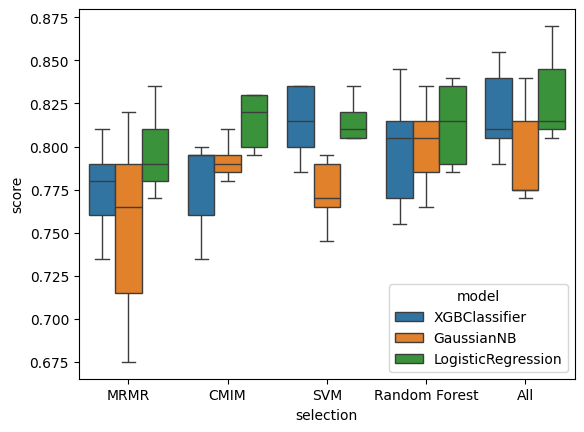

In [37]:
df = pd.DataFrame(mrmr_scores + cmim_scores + svm_scores + rf_scores + all_scores, columns=['selection', 'model', 'score'])
sns.boxplot(data=df, x='selection', y='score', hue='model')
plt.show()

### Frogs

In [40]:
df = pd.read_csv('./datasets/frogs.csv')
df = df.drop(columns=['RecordID', 'Family', 'Genus'])
df.head()

MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
0       1.0  0.152936 -0.105586  0.200722  0.317201  0.260764  0.100945   
1       1.0  0.171534 -0.098975  0.268425  0.338672  0.268353  0.060835   
2       1.0  0.152317 -0.082973  0.287128  0.276014  0.189867  0.008714   
3       1.0  0.224392  0.118985  0.329432  0.372088  0.361005  0.015501   
4       1.0  0.087817 -0.068345  0.306967  0.330923  0.249144  0.006884   

   MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_14  MFCCs_15  MFCCs_16  MFCCs_17  \
0 -0.150063 -0.171128  0.124676  ...  0.082245  0.135752 -0.024017 -0.108351   
1 -0.222475 -0.207693  0.170883  ...  0.022786  0.163320  0.012022 -0.090974   
2 -0.242234 -0.219153  0.232538  ...  0.050791  0.207338  0.083536 -0.050691   
3 -0.194347 -0.098181  0.270375  ... -0.011567  0.100413 -0.050224 -0.136009   
4 -0.265423 -0.172700  0.266434  ...  0.037439  0.219153  0.062837 -0.048885   

   MFCCs_18  MFCCs_19  MFCCs_20  MFCCs_21  MFCCs_22         Species  
0 -0.077623 -0.009568  0.057684  0.118680  0.014038  AdenomeraAndre  
1 -0.056510 -0.035303  0.020140  0.082263  0.029056  AdenomeraAndre  
2 -0.023590 -0.066722 -0.025083  0.099108  0.077162  AdenomeraAndre  
3 -0.177037 -0.130498 -0.054766 -0.018691  0.023954  AdenomeraAndre  
4 -0.053074 -0.088550 -0.031346  0.108610  0.079244  AdenomeraAndre  

[5 rows x 23 columns]

In [41]:
X = df.drop('Species', axis=1).values
y = df['Species'].values

X_disc, X, y = preprocess_data(X, y)

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=48)

cmim_scores = []
mrmr_scores = []
svm_scores = []
rf_scores = []
all_scores = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), total=5):
    X_train, X_test = X[train_index], X[test_index]
    X_disc_train, X_disc_test = X_disc[train_index], X_disc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(f'Fold {i+1}')

    selected_mrmr = criterion_feature_selection(X_disc_train, y_train, J_mrmr)
    print(f'MRMR, selected: {len(selected_mrmr)}')

    selected_cmim = criterion_feature_selection(X_disc_train, y_train, J_cmim)
    print(f'CMIM, selected: {len(selected_cmim)}')
    
    selected_svm = svm_feature_selection(X_train, y_train)
    print(f'SVM, selected: {len(selected_svm)}')

    selected_rf = rf_feature_selection(X_train, y_train)
    print(f'Random Forest, selected: {len(selected_rf)}')

    for model in [XGBClassifier, GaussianNB, LogisticRegression]:
        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_mrmr], y_train).predict(X_disc_test[:, selected_mrmr]))
        mrmr_scores.append({'selection':'MRMR', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_cmim], y_train).predict(X_disc_test[:, selected_cmim]))
        cmim_scores.append({'selection':'CMIM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_svm], y_train).predict(X_test[:, selected_svm]))
        svm_scores.append({'selection':'SVM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_rf], y_train).predict(X_test[:, selected_rf]))
        rf_scores.append({'selection':'Random Forest', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train, y_train).predict(X_test))
        all_scores.append({'selection':'All', 'model': model.__name__, 'score': score})

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1
MRMR, selected: 5
CMIM, selected: 5
SVM, selected: 22
Random Forest, selected: 5
Fold 2
MRMR, selected: 5
CMIM, selected: 5
SVM, selected: 22
Random Forest, selected: 5
Fold 3
MRMR, selected: 5
CMIM, selected: 4
SVM, selected: 21
Random Forest, selected: 7
Fold 4
MRMR, selected: 5
CMIM, selected: 5
SVM, selected: 21
Random Forest, selected: 5
Fold 5
MRMR, selected: 5
CMIM, selected: 4
SVM, selected: 22
Random Forest, selected: 5


In [43]:
df = pd.DataFrame(mrmr_scores + cmim_scores + svm_scores + rf_scores + all_scores, columns=['selection', 'model', 'score'])
sns.boxplot(data=df, x='selection', y='score', hue='model')
plt.show()

### Sonar

In [51]:
df= pd.read_table('./datasets/sonar.data', delimiter=',', header=None)
df.head()

0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0.0052  0.0044   R  
2  0.0095  0.0078   R  
3  0.0040  0.0117   R  
4  0.0107  0.0094   R  

[5 rows x 61 columns]

In [52]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_disc, X, y = preprocess_data(X, y)

In [53]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=48)

cmim_scores = []
mrmr_scores = []
svm_scores = []
rf_scores = []
all_scores = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y)), total=5):
    X_train, X_test = X[train_index], X[test_index]
    X_disc_train, X_disc_test = X_disc[train_index], X_disc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(f'Fold {i+1}')

    selected_mrmr = criterion_feature_selection(X_disc_train, y_train, J_mrmr)
    print(f'MRMR, selected: {len(selected_mrmr)}')

    selected_cmim = criterion_feature_selection(X_disc_train, y_train, J_cmim)
    print(f'CMIM, selected: {len(selected_cmim)}')
    
    selected_svm = svm_feature_selection(X_train, y_train)
    print(f'SVM, selected: {len(selected_svm)}')

    selected_rf = rf_feature_selection(X_train, y_train)
    print(f'Random Forest, selected: {len(selected_rf)}')

    for model in [XGBClassifier, GaussianNB, LogisticRegression]:
        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_mrmr], y_train).predict(X_disc_test[:, selected_mrmr]))
        mrmr_scores.append({'selection':'MRMR', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_disc_train[:, selected_cmim], y_train).predict(X_disc_test[:, selected_cmim]))
        cmim_scores.append({'selection':'CMIM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_svm], y_train).predict(X_test[:, selected_svm]))
        svm_scores.append({'selection':'SVM', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train[:, selected_rf], y_train).predict(X_test[:, selected_rf]))
        rf_scores.append({'selection':'Random Forest', 'model': model.__name__, 'score': score})

        score = accuracy_score(y_test, model().fit(X_train, y_train).predict(X_test))
        all_scores.append({'selection':'All', 'model': model.__name__, 'score': score})

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1
MRMR, selected: 6
CMIM, selected: 1
SVM, selected: 24
Random Forest, selected: 10
Fold 2
MRMR, selected: 1
CMIM, selected: 1
SVM, selected: 3
Random Forest, selected: 15
Fold 3
MRMR, selected: 1
CMIM, selected: 1
SVM, selected: 10
Random Forest, selected: 16
Fold 4
MRMR, selected: 3
CMIM, selected: 1
SVM, selected: 19
Random Forest, selected: 10
Fold 5
MRMR, selected: 7
CMIM, selected: 1
SVM, selected: 10
Random Forest, selected: 12


In [54]:
df = pd.DataFrame(mrmr_scores + cmim_scores + svm_scores + rf_scores + all_scores, columns=['selection', 'model', 'score'])
sns.boxplot(data=df, x='selection', y='score', hue='model')
plt.show()